# Explore data
To see how we can use our data, we do some investigation.

In [1]:
# Load libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError

C:\Users\Rinze\.conda\envs\matrix\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [85]:
# Load pickle file
df = pd.read_pickle("../data/combination.pkl")

In [3]:
df.shape

(8048, 473)

In [86]:
# Temp solution
df.rename(columns={"rf_plat dak": "rf_plat_dak"}, 
          inplace=True)
df.drop(columns=["xf_attic"], inplace=True)
df.drop(df[df['asking_price'] == 0].index, inplace=True)
df.drop(df[(df.asking_price > 10000000) 
           | (df.asking_price < 100000)]
        .index, inplace=True)

In [5]:
no_ne = [col for col in df.columns if not col.startswith("ne")]
no_ne

['address',
 'asking_price',
 'price_m2',
 'days_online',
 'service_fees_pm',
 'vve_contribution',
 'build_year',
 'land_m2',
 'property_m3',
 'living_m2',
 'floors',
 'apartment_level',
 'garden',
 'balcony',
 'storage_type',
 'parking',
 'vve_kvk',
 'vve_am',
 'vve_per_contr',
 'vve_reserve_fund',
 'vve_maintenance',
 'vve_insurance',
 'num_bathrooms',
 'num_toilets',
 'rooms',
 'bedrooms',
 'pt_landhuis',
 'pt_open_portiek',
 'pt_geschakelde_woning',
 'pt_split-level_woning',
 'pt_portiekwoning',
 'pt_benedenwoning',
 'pt_eengezinswoning',
 'pt_geschakelde_2-onder-1-kapwoning',
 'pt_waterwoning',
 'pt_service_flat',
 'pt_drive-in_woning',
 'pt_tussenwoning',
 'pt_vrijstaande_woning',
 'pt_herenhuis',
 'pt_appartement',
 'pt_kwadrant_woning',
 'pt_halfvrijstaande_woning',
 'pt_bovenwoning',
 'pt_appartement_met_open_portiek',
 'pt_beneden_+_bovenwoning',
 'pt_dubbel_bovenhuis',
 'pt_dubbel_benedenhuis',
 'pt_bungalow',
 'pt_2-onder-1-kapwoning',
 'pt_dubbel_bovenhuis_met_open_portiek

In [6]:
# Use a subset without neighborhoods for correlation check
subset = df[no_ne]

## Correlation check
Initially we want to know what factors have a big influence on the asking price.

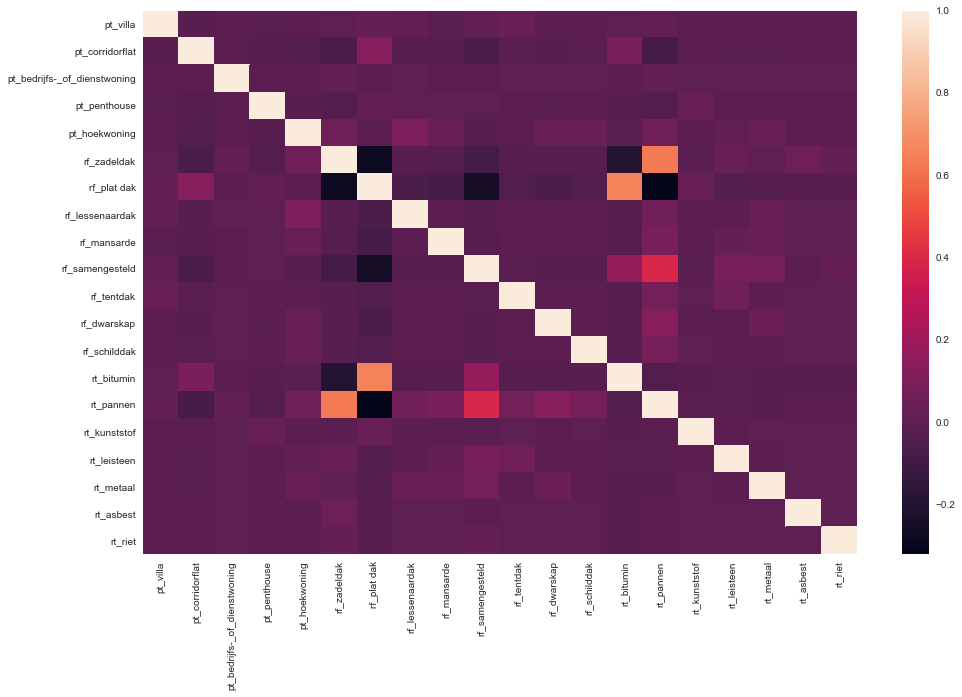

In [50]:
# Produce a heatmap 
fig, ax = plt.subplots(figsize=(16,10))
corr = subset.corr()
sns.heatmap(corr.iloc[50:70, 50:70])

There seems to be high correlation between the various columns:
- VVE columns
- property_m3 vs living_m2
- appartement_met_open_portiek vs open_portiek
- price_m2
so we can drop a few of them.

It appears something went wrong with the attic column so we drop that, too.

In [39]:
# Drop columns
vve = [col 
       for col in df.columns 
       if col.startswith("vve") 
       and col not in ["vve_contribution", "vve_maintenance"]]
others = ["rt_pannen", "rf_plat_dak", 
          "pt_appartement_met_open_portiek", "address", "price_m2"]

df = df.drop(columns=vve + others)

For some reason the model doesn't work when we remove all these columns, so only address and price_m2 are removed. 

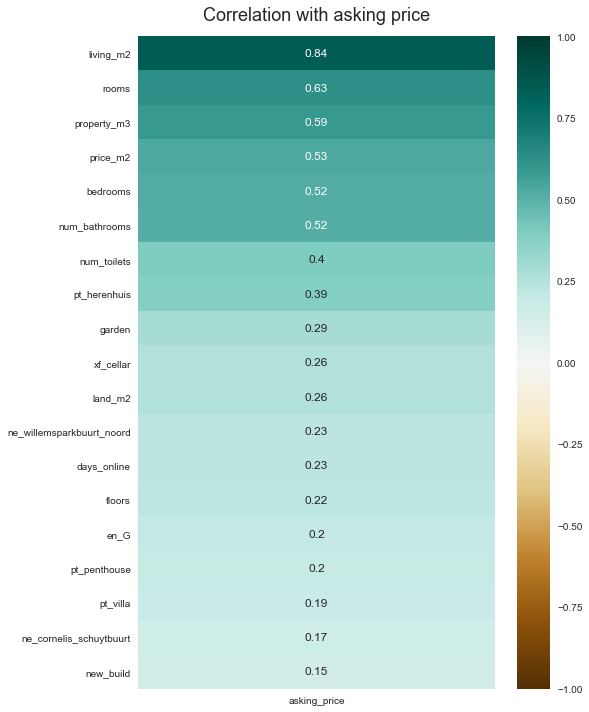

In [8]:
# Correlation viewed related to asking price
corr_series = (df.corr()[["asking_price"]]
               .sort_values(by="asking_price", ascending=False))

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_series[1:20], 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='BrBG')
heatmap.set_title("Correlation with asking price", 
                  fontdict={'fontsize':18}, 
                  pad=16);

## Outliers

## Preprocessing

In [87]:
# Select column names of factors with more than 2 values
num_cols = [col for col in df.columns 
            if df[col].nunique() > 2 
            and df[col].dtype in ["int64", "float64"] 
            and col != "asking_price"]

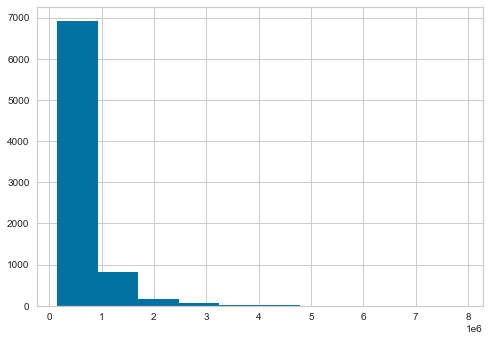

In [7]:
#df[(df.asking_price > 10000000) | (df.asking_price < 100000)]
df.asking_price.hist()

In [19]:
from scipy import stats
o = df[num_cols].copy()
o[(np.abs(stats.zscore(o)) < 3).all(axis=1)]

,price_m2,days_online,service_fees_pm,vve_contribution,build_year,land_m2,property_m3,living_m2,floors,apartment_level,num_bathrooms,num_toilets,rooms,bedrooms
1,1.517462,-0.262502,-0.022611,-0.906418,-0.848136,0.789490,-0.238396,-0.493492,0.236840,-0.820282,1.619764,-1.207624,-0.407809,-0.322014
2,-0.982202,-0.262502,-0.021873,-0.906418,0.989350,1.585832,1.317348,0.816507,0.940524,-0.820282,1.619764,-1.207624,0.844875,1.370932
3,-0.555963,-0.301324,-0.022611,-0.906418,-0.412942,1.628493,-0.394595,-0.617411,0.236840,-0.820282,-0.068778,0.362639,-0.407809,-0.322014
4,-0.205188,-0.262502,-0.022611,-0.906418,0.409091,1.969782,-0.219652,0.391642,0.236840,-0.820282,-0.068778,0.362639,0.218533,0.524459
5,-1.646801,-0.281913,-0.022611,-0.906418,0.957113,1.472069,0.823759,0.781102,0.940524,-0.820282,-0.068778,0.362639,0.844875,1.370932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8023,0.061797,-0.534255,-0.022611,0.868539,1.069941,-0.305480,0.180218,0.108399,-0.466844,0.407617,-0.068778,0.362639,-0.407809,-0.322014
8024,0.342313,-0.534255,-0.017869,0.033265,-0.332350,-0.305480,-0.238396,-0.192547,0.236840,0.407617,-0.068778,0.362639,0.218533,-0.322014
8025,0.639483,-0.534255,-0.022611,0.160853,-0.251759,-0.305480,-0.744481,-0.723627,1.644208,0.407617,-0.068778,0.362639,-0.407809,-0.322014
8026,-1.453198,-0.534255,-0.022611,-0.906418,1.102178,1.571612,1.017446,0.586372,0.236840,-0.820282,-0.068778,0.362639,0.844875,1.370932


## Split data

In [88]:
# Set variables
# X = df[[col for col in df.columns if col != "asking_price"]]
# "pt_appartement_met_open_portiek", , "price_m2"
to_drop = ["asking_price", "address"]
X = df[[col for col in df.columns if col not in to_drop ]]
y = df["asking_price"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=7)

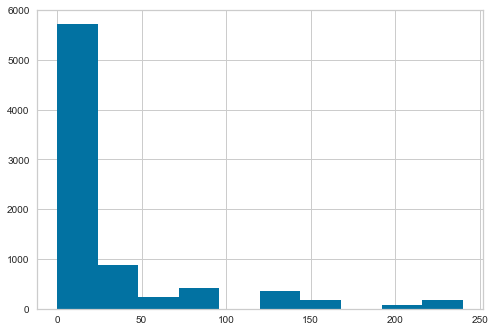

In [41]:
df["days_online"].hist()

In [22]:
df.reset_index(drop=True, inplace=True)

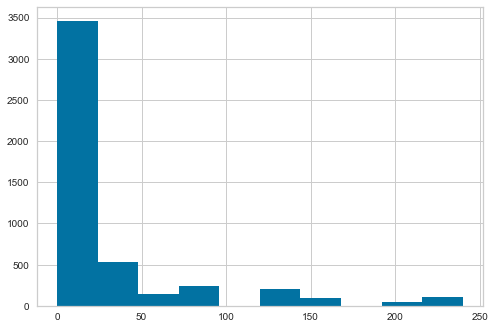

In [89]:
# Fit scaler model 
std = StandardScaler()
scaled_fit = std.fit(X_train[num_cols])

# Apply to dataframe
for xf in [X_train, X_test]:
    xf.reset_index(drop=True, inplace=True)
    scaled = pd.DataFrame(scaled_fit.transform(xf[num_cols]), 
                                columns=num_cols)
    xf = xf.drop(columns=num_cols, axis=1)
    xf = xf.merge(scaled, left_index=True, right_index=True, how="outer")

X_train["days_online"].hist()

## Linear regression
Now we train a model to check for linear regression.

In [90]:
# Instantiate the class
lin_model = linear_model.LinearRegression()
# Create the model
lin_model.fit(X_train, y_train)
score = lin_model.score(X_train, y_train)
print(f"R2: {score:.5f}")

R2: 0.94580


Our initial score (0.70) is not very high. This could have various reasons. Most obvious is the way we selected our features. 
Edit: By adding living_m2 and scaling after the split we achieved much better values.

In [25]:
def visualize_model(plot, model, train, test):
    visualizer = plot(model)
    visualizer.fit(*train)
    visualizer.score(*test)
    visualizer.show() 

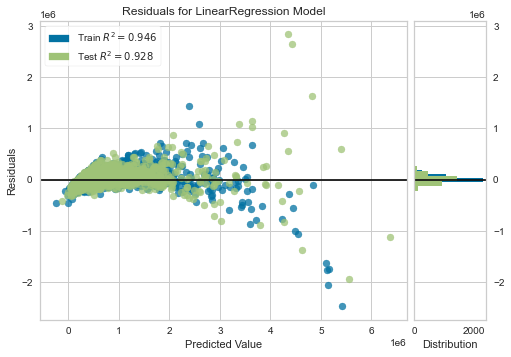

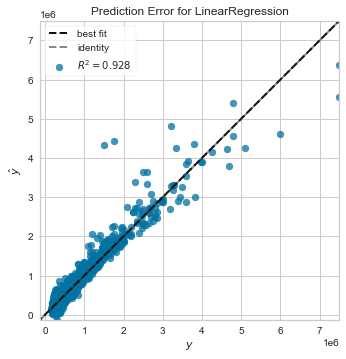

In [84]:
#fig, axes = plt.subplots(2, 1, figsize=(16,10))
for i, plot in enumerate([ResidualsPlot, PredictionError]):
    visualize_model(plot, lin_model, (X_train, y_train), (X_test, y_test))

#### Interpretation
The points are not randomly dispersed around the horizontal axis,  which means that a linear regression model is probably not appropriate for the data and we should use a non-linear model. The R<sup>2</sup> for the training set is very good, however the R<sup>2</sup> for the test set is average, which also shows in the fact that the train data (green) is normally distributed around 0, but not the test data.

# Externalize in full func
To be able to run the full thing in one go, we save the whole thing in a external script.

In [1]:
import importlib
importlib.import_module("modelling")
import modelling

C:\Users\Rinze\.conda\envs\matrix\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
mdl = modelling.MachineLearnModel("combination.pkl")


-----LR-----




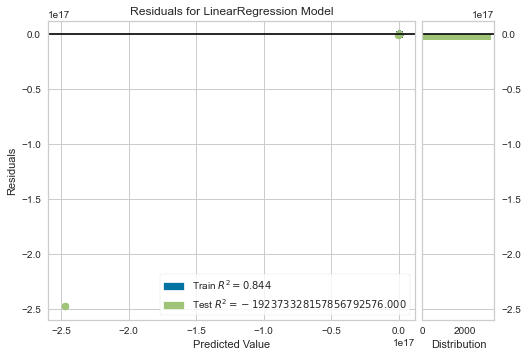

Model achieved an mean absolute error of 66317.299.
R2 score is -192373328157856792576.000

finished


In [3]:
models = ["LR"
          #, "DT", "RF"
         ]
for model in models:
    mdl.evaluate_model(model, viz=True)
print("\nfinished")